In [3]:
import sys
sys.path.insert(0, "/home/jogi/git/repository/meta_learner")
if "/home/jogi/.local/lib/python2.7/site-packages" in sys.path:
    sys.path.remove("/home/jogi/.local/lib/python2.7/site-packages")

import matplotlib
import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib inline

from datetime import datetime
from pytz import timezone
import itertools
import copy

import numpy as np
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import init

import numpy as np
import dill
import os
from collections import OrderedDict


from utils.experiment import Experiment
from utils.common import get_model, create_def_argparser, create_logger, softmax
from utils.plots import loss_plot, param_error_plot, plot_qt_probs, plot_dist_optimization_steps
from utils.plots import plot_actsb_qts, plot_image_map_data, plot_image_map_losses
from utils.plots import plot_loss_over_tsteps, plot_halting_step_stats_with_loss, plot_loss_versus_halting_step
from utils.probs import TimeStepsDist, ConditionalTimeStepDist
from utils.config import config
from val_optimizer import validate_optimizer
from utils.regression import RegressionFunction, L2LQuadratic, RegressionWithStudentT
from utils.helper import tensor_and, tensor_any
from utils.batch_handler import ACTBatchHandler
from utils.epoch import Epoch, halting_step_stats
from models.rnn_optimizer import MetaLearner, AdaptiveMetaLearnerV1, AdaptiveMetaLearnerV2
from models.sb_act_optimizer import StickBreakingACTBaseModel

from utils.regression import RegressionFunction, L2LQuadratic, neg_log_likelihood_loss, RosenBrock
from utils.regression import RegressionWithStudentT

%load_ext autoreload
%autoreload 2

In [4]:
expers_to_load = [# Meta V1 model regression
                  (True, "run_20171005_09_34_28_metaV1_20ep_5ops_lr4e05"),
                  (True, "run_20171005_09_43_04_metaV1_40ep_10ops_lr4e05"), # this is a very unstable training length!
                  (True, "run_20170930_15_17_50_metaV1_45ep_25ops_lr4e05"), # trunc_bptt_step=20
                  (False, "run_20170930_14_55_27_metaV1_100ep_50ops_lr4e05"), # =50
                  (False, "run_20170930_17_40_00_metaV1_60ep_50ops_lr4e05"), # =30
                  (True, "run_20170930_12_21_10_metaV1_50ep_50ops_lr4e05"), # =20
                  (False, "run_20170930_16_28_40_metaV1_35ep_50ops_lr4e05"), # =10
                  (True, "run_20170930_13_48_07_metaV1_40ep_100ops_lr4e05")] # =100



In [5]:
## IMPORTANT ---- NUMBER OF STEPS FOR TEST EVALUATION
MAX_EVAL_STEPS = 35

without_models = False

path_ext = None
experiments = []
models = []
new_experiments = []
explogger = None
m = 0
if 'logger' in vars() or 'logger' in globals():
    pass
else:
    logger = create_logger(exper=None, file_handler=True, output_dir="/home/jogi/git/repository/meta_learner/logs")

for e, exp_path in enumerate(expers_to_load):
    if exp_path[0]:
        
        if path_ext is not None:
            exp_file_path = os.path.join(path_ext, exp_path[1])
        else:
            exp_file_path = exp_path[1]
            
        exp = Experiment.load(exp_file_path, do_log=True, meta_logger=logger)
            
        if "act" in exp.args.model:
            print("{} Loading model {} (q-prob {:.2f}) / {}".format(m, exp.args.model, 
                                                                    exp.config.ptT_shape_param,
                                                                    exp.args.log_dir))
        else:
            print("{} Loading model {} / {}".format(m, exp.args.model, exp.args.log_dir))
        
        experiments.append(exp)
        m += 1
        if not without_models:
            num_inputs = 1
            if exp.args.problem == 'mlp':
                num_inputs = 3
            models.append(get_model(exp, num_inputs, retrain=True))
        new_experiments.append(Experiment(exp.args, exp.config, set_seed=True))
        new_experiments[-1].batch_handler_class = experiments[-1].batch_handler_class
        new_experiments[-1].output_dir = experiments[-1].output_dir
        new_experiments[-1].reset_val_stats()
        new_experiments[-1].meta_logger = logger
        new_experiments[-1].validation_handler_class = experiments[-1].validation_handler_class
        new_experiments[-1].training_horizon = experiments[-1].config.T
        new_experiments[-1].avg_num_opt_steps = experiments[-1].avg_num_opt_steps

INFO - created local logger for experiment with model metaV1_regression_T_5ops
INFO - INFO - loaded existing model from file logs/run_20171005_09_34_28_metaV1_20ep_5ops_lr4e05/metaV1_regression_T_5ops.pkl
INFO - Note: MetaLearner is running on GPU
INFO - ['linear1.weight', 'linear1.bias', 'lstms.0.fc_i2h.weight', 'lstms.0.fc_i2h.bias', 'lstms.0.fc_h2h.weight', 'lstms.0.fc_h2h.bias', 'lstms.1.fc_i2h.weight', 'lstms.1.fc_i2h.bias', 'lstms.1.fc_h2h.weight', 'lstms.1.fc_h2h.bias', 'linear_out.weight']
INFO - created local logger for experiment with model metaV1_regression_T_10ops
INFO - INFO - loaded existing model from file logs/run_20171005_09_43_04_metaV1_40ep_10ops_lr4e05/metaV1_regression_T_10ops.pkl
INFO - Note: MetaLearner is running on GPU
INFO - ['linear1.weight', 'linear1.bias', 'lstms.0.fc_i2h.weight', 'lstms.0.fc_i2h.bias', 'lstms.0.fc_h2h.weight', 'lstms.0.fc_h2h.bias', 'lstms.1.fc_i2h.weight', 'lstms.1.fc_i2h.bias', 'lstms.1.fc_h2h.weight', 'lstms.1.fc_h2h.bias', 'linear_out.

0 Loading model metaV1_regression_T_5ops / run_20171005_09_34_28_metaV1_20ep_5ops_lr4e05
1 Loading model metaV1_regression_T_10ops / run_20171005_09_43_04_metaV1_40ep_10ops_lr4e05
2 Loading model metaV1_regression_T_25ops / run_20170930_15_17_50_metaV1_45ep_25ops_lr4e05
3 Loading model metaV1_regression_T_50ops / run_20170930_12_21_10_metaV1_50ep_50ops_lr4e05
4 Loading model metaV1_regression_T_100ops / run_20170930_13_48_07_metaV1_40ep_100ops_lr4e05


In [8]:
# del new_experiments
new_experiments = []
unrolled_steps=200
num_of_funcs = 10000

if 'logger' in vars() or 'logger' in globals():
    pass
else:
    logger = create_logger(exper=None, file_handler=True, output_dir="/home/jogi/git/repository/meta_learner/logs")

for exper in expers_to_load:
    if exper[0]:
        
        path_to_exp = exper[1] + "/" + "exp_eval_stats_" + str(num_of_funcs) + "_" + str(unrolled_steps) +"steps.dll"
        print("Loading experiment {} / path {}".format(exper[1], path_to_exp))
        new_experiments.append(Experiment.load(path_to_exp=path_to_exp,
                                               full_path=True))
        if new_experiments[-1].meta_logger is None:
            new_experiments[-1].meta_logger = logger
print("Ready")

Loading experiment run_20171005_09_34_28_metaV1_20ep_5ops_lr4e05 / path run_20171005_09_34_28_metaV1_20ep_5ops_lr4e05/exp_eval_stats_10000_200steps.dll
Loading experiment run_20171005_09_43_04_metaV1_40ep_10ops_lr4e05 / path run_20171005_09_43_04_metaV1_40ep_10ops_lr4e05/exp_eval_stats_10000_200steps.dll
Loading experiment run_20170930_15_17_50_metaV1_45ep_25ops_lr4e05 / path run_20170930_15_17_50_metaV1_45ep_25ops_lr4e05/exp_eval_stats_10000_200steps.dll
Loading experiment run_20170930_12_21_10_metaV1_50ep_50ops_lr4e05 / path run_20170930_12_21_10_metaV1_50ep_50ops_lr4e05/exp_eval_stats_10000_200steps.dll
Loading experiment run_20170930_13_48_07_metaV1_40ep_100ops_lr4e05 / path run_20170930_13_48_07_metaV1_40ep_100ops_lr4e05/exp_eval_stats_10000_200steps.dll
Ready


In [6]:
with open("data/test_regression_T_10000_10_1.0_10.dll", 'rb') as f:
     test_funcs = dill.load(f)
print("Ready")

Ready


INFO - Successfully saved fig figures/10reg_T_LSTM_all_H_100_200.png


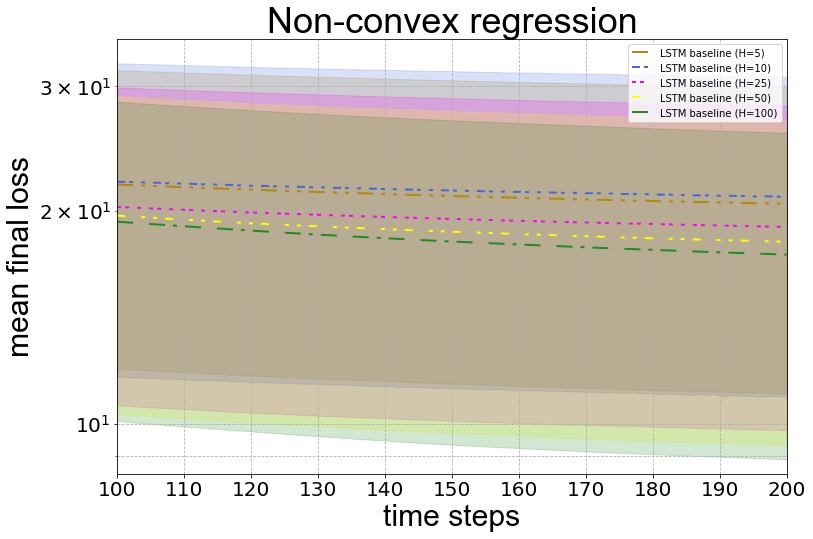

In [12]:
#new_exp_select = [new_experiments[0], new_experiments[1], new_experiments[2], new_experiments[4],
#                 new_experiments[6]] 
#, new_experiments[4]] 
part = 2
if part == 1:
    min_step = 0
    max_step = 100
    y_lim = [10,60 ]
    log_scale  = False
elif part == 2:
    min_step = 100
    max_step = 200
    log_scale = True
    y_lim=[8.5, 35]
else:
    log_scale = True
    min_step = 0
    max_step = 100
    y_lim=[8.5, 56]
    
best_val_runs, lowest_value = plot_loss_over_tsteps(new_experiments, do_show=True, 
                                              do_save=True, 
                                              plot_best=False,
                                              fig_name="10reg_T_LSTM_all_H_" + str(min_step) + "_" + str(max_step),  
                                              loss_type="loss",
                                              min_step=min_step,
                                              max_step=max_step,
                                              sort_exper="Non-convex regression",
                                              log_scale=log_scale,
                                              y_lim=y_lim,
                                              with_stddev=True,
                                              runID=None)
# label_annotation=[" - BPTT(50)", " - BPTT(30)", " - BPTT(30)", " - BPTT(10)", " - BPTT(100)"])

In [ ]:
# eval_new_val_expers = [new_experiments[0], new_experiments[3]] #, new_experiments[5]]

best_val_runs, lowest_value = plot_val_result(new_experiments, 
                                              do_show=True, 
                                              do_save=True, 
                                              plot_best=False,
                                              loss_type="loss",
                                              fig_name="expv5_val_results_1000_loss_10ops")

In [ ]:
# eval_expers = new_exp_only = [experiments[0], experiments[1], experiments[2]]
plot_parm_loss_steps(experiments, num_of_plots=4, do_show=True, 
                     do_save=False, loss_type="loss", log_scale=False, max_step=20,
                    fig_name="metaV2_val_loss_during_training")

In [7]:
exp_idx = 1
model = models[exp_idx]

max_steps = 200
# new_experiments[exp_idx].model_path

new_experiments[exp_idx].epoch = 400
new_experiments[exp_idx].config.max_val_opt_steps = max_steps
new_experiments[exp_idx].config.T = max_steps
new_experiments[exp_idx].type_prior = "geometric"


epoch_obj = Epoch()
epoch_obj.start(new_experiments[exp_idx])
print("Validating model {} with q-prob {:.3f}".format(model.name, experiments[exp_idx].config.ptT_shape_param))
new_experiments[exp_idx].eval(epoch_obj, model, functions=test_funcs, save_run=None, save_model=False)
print("End....")
new_experiments[exp_idx].save("exp_eval_stats_10000_"+str(max_steps) + "steps.dll")

INFO - ---------------------------------------------------------------------------------------
INFO - INFO - Epoch 400: Validating model metaV1_regression_T_10ops with 10000 functions


Validating model metaV1_regression_T_10ops with q-prob 0.700


INFO - INFO - Epoch 400, elapsed time 8.16 seconds: 
INFO - INFO - Epoch 400: Final validation stats: total-step-losses / final-step loss / final-true_min: 4.647e+03/20.95/9.5
INFO - INFO - Epoch 400: Final step losses: [ 56.32   42.571  37.513  35.747  34.156  32.625  31.523  30.66   30.004
  29.437  28.898  28.409  27.974  27.6    27.274  26.968  26.687  26.423
  26.182  25.972  25.776  25.586  25.416  25.253  25.114  24.972  24.842
  24.727  24.612  24.508  24.409  24.31   24.23   24.144  24.076  23.996
  23.923  23.859  23.79   23.737  23.679  23.616  23.575  23.513  23.462
  23.424  23.366  23.321  23.289  23.237  23.205  23.173  23.125  23.088
  23.052  23.021  22.992  22.96   22.916  22.893  22.86   22.836  22.818
  22.781  22.747  22.725  22.698  22.681  22.649  22.62   22.589  22.565
  22.544  22.534  22.486  22.477  22.456  22.428  22.418  22.393  22.366
  22.354  22.333  22.31   22.296  22.274  22.246  22.234  22.215  22.194
  22.189  22.15   22.132  22.137  22.105  22.082  

End....


In [9]:
X = np.vstack(new_experiments[2].val_stats["halt_step_funcs"].values())

In [ ]:

exp_idx = 3
max_steps = 200
new_experiments[exp_idx].epoch = 400
new_experiments[exp_idx].config.max_val_opt_steps = max_steps
new_experiments[exp_idx].config.T = max_steps
new_experiments[exp_idx].config.qt_threshold = 0.95
new_experiments[exp_idx].reset_val_stats()
if new_experiments[exp_idx].meta_logger is None:
    new_experiments[exp_idx].meta_logger = logger
# the same object for the validation data
model = models[exp_idx]
model.opt_step_hist_val = np.zeros(new_experiments[exp_idx].config.max_val_opt_steps)
model.qt_hist_val = OrderedDict([(i, np.zeros(i)) 
                                 for i in np.arange(1, new_experiments[exp_idx].config.max_val_opt_steps + 1)])
print("Validating model {} with q-prob {:.3f}".format(model.name, experiments[exp_idx].config.ptT_shape_param))

if "act" in model.name:
    model.init_qt_statistics(new_experiments[exp_idx].config)

validate_optimizer(model, new_experiments[exp_idx], explogger, val_set=test_funcs, 
                   max_steps=max_steps, verbose=False, plot_func=False, show_plot=False, save_plot=False,
                   num_of_plots=5, save_model=False, save_qt_prob_funcs=False, 
                   save_run="exp_eval_stats_10000_"+str(max_steps) + "steps")
new_experiments[exp_idx].save("exp_eval_stats_10000_"+str(max_steps) + "steps.dll")

In [ ]:
plot_qt_probs(new_experiments[2], data_set="val", save=True, show=True, 
              plot_prior=False, height=20, width=20, add_info=True)

In [ ]:
from utils.plots import create_exper_label
num_of_plots = 13
T0 = 23
fig = plt.figure(figsize=(8, 25))

for i in range(1, num_of_plots+1):
    T = T0+i
    index = np.arange(1, T+1).astype(int)
    qt = exper.val_stats["qt_hist"][30][T]
    ax1 = plt.subplot(num_of_plots, 1, i)
    plt.bar(index, qt, 0.3, label="q(t|{})".format(T))
    ax1.legend(loc="best")
    
fig_name = "_" + "val" + "_" + create_exper_label(exper)
fig_name = os.path.join(exper.output_dir, config.qt_dist_prefix + fig_name + ".png")
plt.savefig(fig_name, bbox_inches='tight')
plt.close()

INFO - Successfully saved fig logs/run_20170814_17_04_25_metaV1_50ep_100ops_lr3e05/loss_metaV1_50ep_100ops_21:43:29.png


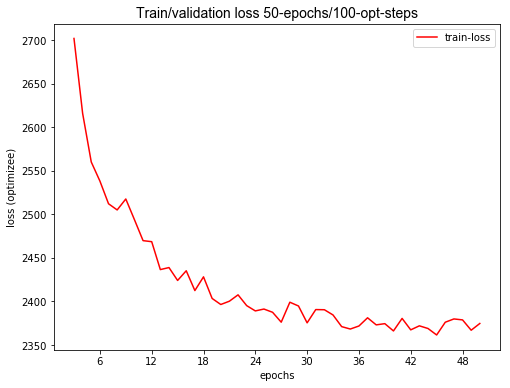

In [41]:
loss_plot(experiments[0], show=True, save=True, validation=False, only_val=False)

In [ ]:
plot_actsb_qts(new_experiments[3], data_set="eval", save=False, show=True, add_info=False, epoch=400, 
              fig_name="qt_dist_test_eval_500steps")

INFO - Successfully saved fig logs/run_20170815_14_33_06_act_sbV2_50ep_nu0.95_lr5e05/T_dist_eval.png


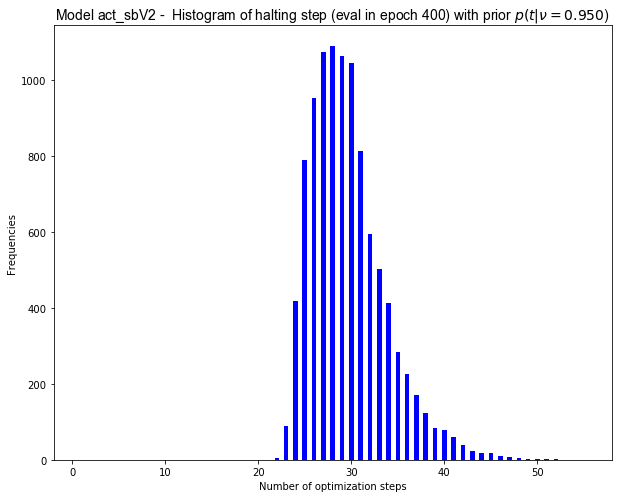

In [79]:
plot_dist_optimization_steps(new_experiments[2], data_set="eval", save=True, show=True, epoch=400)

INFO - Successfully saved fig logs/run_20170829_17_23_19_act_sbV3.1_65ep_nu0.6_lr5e05/halting_step_versus_nll_distance.png


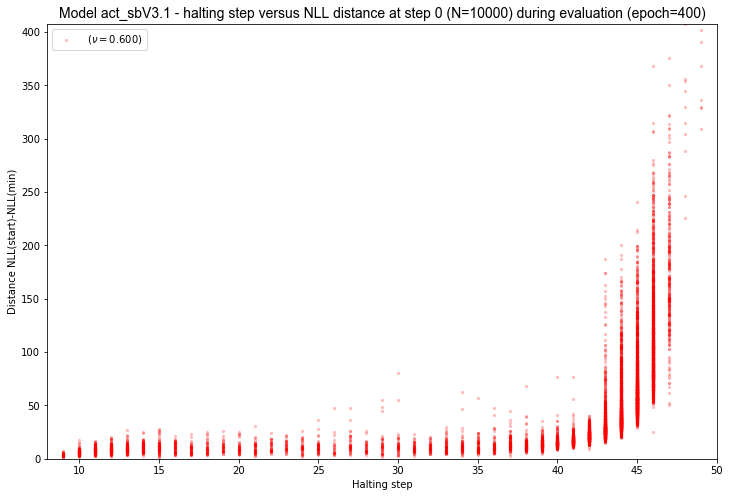

In [6]:
plot_loss_versus_halting_step(new_experiments[1], epoch=400, do_show=True, do_save=True)

INFO - Successfully saved fig logs/run_20170930_18_49_40_metaV1_60ep_50ops_lr1e05/10dregT_50ops_10bptt_20ep_10steps.png


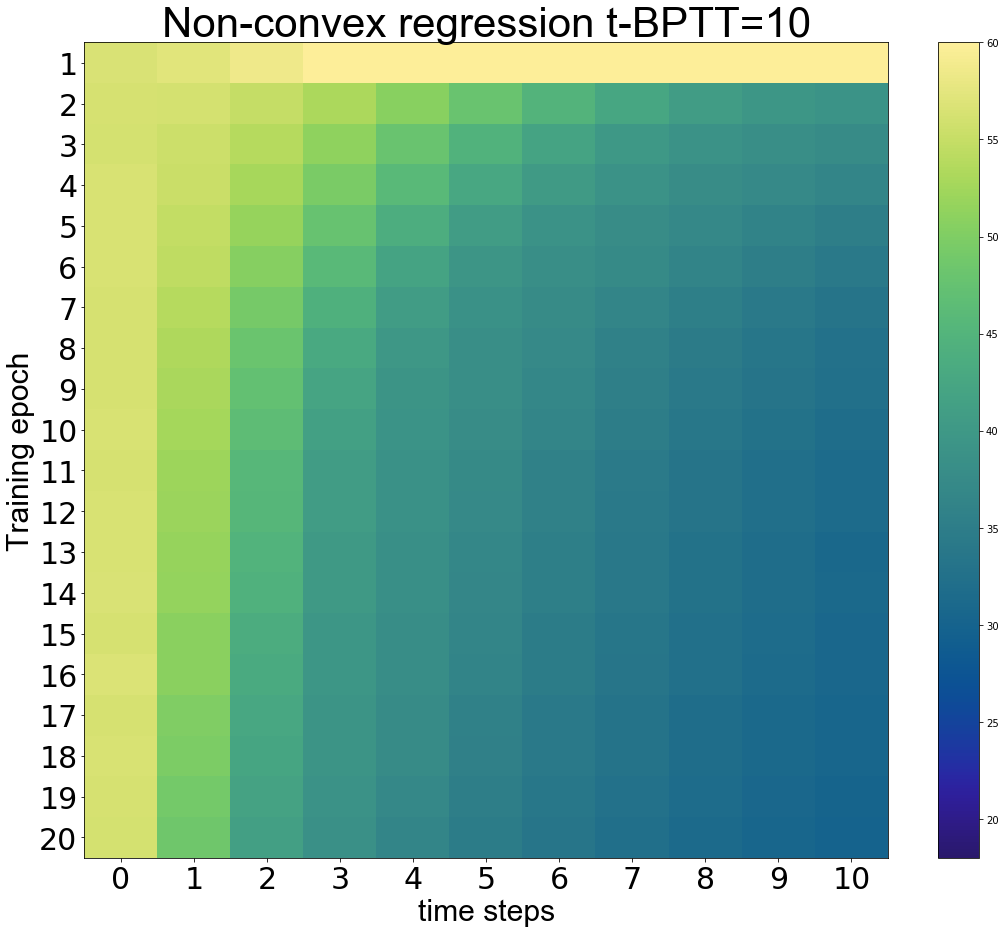

In [15]:
plot_image_map_losses(experiments[3], fig_name="10dregT_50ops_10bptt_20ep_10steps", do_save=True, do_show=True, 
                      max_epoch=20, max_time_step=11, fig_title="Non-convex regression t-BPTT=10", 
                      scale= [18,60], huge=True)

In [5]:
"""
    Generate new test functions
"""
test_funcs = RegressionWithStudentT(n_funcs=10000, n_samples=10, x_dim=10, scale_p=1., shape_p=1, use_cuda=True)
with open("data/test_regression_T_10000_10_1.0_10.dll", 'wb') as f:
     dill.dump(test_funcs, f)
print("Ready")


Ready


In [5]:
funcs = RegressionFunction(n_funcs=10, n_samples=10, stddev=1., x_dim=5, use_cuda=True, 
                                calc_true_params=False)
print(funcs.true_minimum_nll)

Variable containing:
 9.1894
[torch.cuda.FloatTensor of size 1 (GPU 0)]



In [3]:
test_funcs = RegressionFunction(n_funcs=10000, n_samples=10, stddev=1., x_dim=10, use_cuda=True, 
                                calc_true_params=False)
with open("data/test_regression_10000_10_1.0_10.dll", 'wb') as f:
     dill.dump(test_funcs, f)
print("Ready")

Ready


In [6]:
experiments[0].generate_figures()

INFO - Successfully saved fig logs/run_20171001_12_01_01_metaV1_30ep_100ops_lr4e05/loss_train_metaV1_30ep_100ops.png
(100, 30)
INFO - Successfully saved fig logs/run_20171001_12_01_01_metaV1_30ep_100ops_lr4e05/loss_optimizer_train_metaV1_30ep_100ops.png
INFO - Successfully saved fig logs/run_20171001_12_01_01_metaV1_30ep_100ops_lr4e05/loss_eval_metaV1_30ep_100ops.png
(100, 30)
INFO - Successfully saved fig logs/run_20171001_12_01_01_metaV1_30ep_100ops_lr4e05/loss_optimizer_eval_metaV1_30ep_100ops.png
INFO - Successfully saved fig logs/run_20171001_12_01_01_metaV1_30ep_100ops_lr4e05/train_step_loss_map_metaV1_30ep_100ops.png
INFO - Successfully saved fig logs/run_20171001_12_01_01_metaV1_30ep_100ops_lr4e05/T_dist_train.png
INFO - Successfully saved fig logs/run_20171001_12_01_01_metaV1_30ep_100ops_lr4e05/gradient_statistics.png
INFO - Successfully saved fig logs/run_20171001_12_01_01_metaV1_30ep_100ops_lr4e05/eval_step_loss_map_metaV1_30ep_100ops.png
